In [1]:
from IPython.display import clear_output

In [2]:
# Download the required libraries (needed when running outside colab where the environment doesn't come pre-loaded with libraries)

# %pip install torch
# %pip install torchvision
# %pip install matplotlib

clear_output()

In [3]:
import torch
import torch.nn as nn

from torchvision.datasets import CIFAR10
from torchvision.transforms.functional import to_tensor, to_pil_image, resize

from torch.utils.data import DataLoader
from torch.optim import Adam
from torchsummary import summary

import matplotlib.pyplot as plt

# Contents:

1. We'll make a classifier for CIFAR10 dataset in pytorch using CNN architecture

About CIFAR10:

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

![CIFAR-10 image](https://production-media.paperswithcode.com/datasets/4fdf2b82-2bc3-4f97-ba51-400322b228b1.png)


You need to know:

1. **torch** (for impelementation)
2. a little bit of **matplotlib** (for visualization)


Good to have knowledge of:

1. torch dataset and dataloader

# Downloading the dataset

In [4]:
dataset_root = 'data/'

train_dataset = CIFAR10(root=dataset_root, train=True, download=True, transform=to_tensor)
val_dataset = CIFAR10(root=dataset_root, train=False, download=True, transform=to_tensor)

100%|██████████| 170498071/170498071 [00:04<00:00, 40770084.78it/s]


Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


In [5]:
print('Length of train_dataset is', len(train_dataset))
print('Length of val_dataset is'  , len(val_dataset))

Length of train_dataset is 50000
Length of val_dataset is 10000


In [6]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # shuffle : prevent the model from learning the order of the data.
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # no need to shuffle validation data

## Let's visualize the images and it's channels

torch.Size([3, 250, 250])
Number of channels in test_image:  3


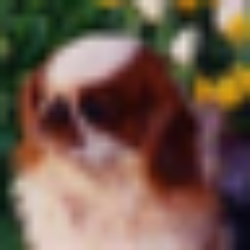

In [7]:
random_img_idx = torch.randint(0, 1000, (1,)).item()

test_image = train_dataset[random_img_idx][0]  # 0 for image part in (image, label) tuple.
test_image = resize(test_image, (250, 250), antialias=None)  # better visualization
print(test_image.shape)
print('Number of channels in test_image: ', test_image.shape[0])
to_pil_image(test_image)

In [8]:
tred, tgreen, tblue = test_image
empty_channel = torch.zeros_like(tred)

tred = [tred, empty_channel, empty_channel]  #R00
tgreen = [empty_channel, tgreen, empty_channel]  #0G0
tblue = [empty_channel, empty_channel, tblue]  #00B

channels = [torch.stack(img) for img in [tred, tgreen, tblue]]

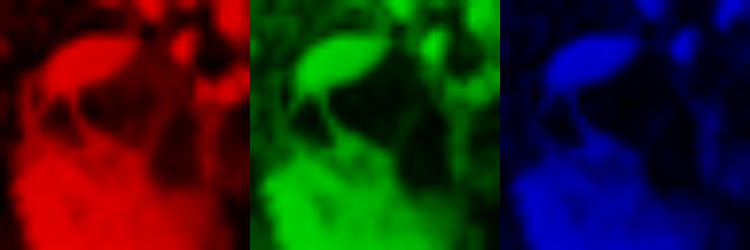

In [9]:
to_pil_image(torch.cat(channels, dim=2))

In [10]:
class Cifar10Classifier(nn.Module):

  def __init__(self):

    super(Cifar10Classifier, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

    self.relu = nn.ReLU()  # Relu isn't learnable. no need to intialize different relu objects for each layer
    self.pool = nn.MaxPool2d(2, 2)  # pool isn't learnable to no need to initialize different pool layers unless we want to change window size

    self.fc1 = nn.Linear(128 * 4 * 4, 512)
    self.fc2 = nn.Linear(512, 10)

    self.softmax = nn.Softmax(dim=-1)

  def forward(self, x: torch.Tensor):

    single_input = False
    if x.ndim == 3:  # 3 dimensions mean [C, H, W] instead of [B, C, H, W] so we're dealing with a single image
      x = x.unsqueeze(dim=0)  # convert [C, H, W] to [1, C, H, W] where 1 will act as batch size

      # keep track of whether input was one (non-batch) image.
      # If so, we want to convert it back to the same format after inference for consistency purposes
      single_input = True

    x = self.pool(self.relu(self.conv1(x)))
    x = self.pool(self.relu(self.conv2(x)))
    x = self.pool(self.relu(self.conv3(x)))
    x = x.flatten(start_dim=1)
    x = self.relu(self.fc1(x))
    x = self.fc2(x)
    x = self.softmax(x)

    if single_input:
      x = x.squeeze(dim=0)  # or x = x[0]

    return x


In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # checks if machine supports cuda and if it does, we use that, otherwise cpu
model = Cifar10Classifier().to(device)

In [12]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
              ReLU-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]          73,856
              ReLU-8            [-1, 128, 8, 8]               0
         MaxPool2d-9            [-1, 128, 4, 4]               0
           Linear-10                  [-1, 512]       1,049,088
             ReLU-11                  [-1, 512]               0
           Linear-12                   [-1, 10]           5,130
          Softmax-13                   [-1, 10]               0
Total params: 1,147,466
Trainable param

In [13]:
print(model)

Cifar10Classifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (softmax): Softmax(dim=-1)
)


In [14]:
num_epochs = 30
lr = 1e-4

train_losses = []
val_losses = []

optimizer = Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()  # multi-class

model.to(device)  # we need to send all input tensors as well as our model to this device. by default they are on cpu

print(f'Using device {device}')

Using device cuda


In [15]:
%%time
for epoch_no in range(num_epochs):

  model.train()  # convert to train model. This turns out train-specific layers in the model (if you dont know about them, an example of them is dropout. more on this later)

  epoch_weighted_loss = 0

  for batch_X, batch_y in train_loader:

    batch_X = batch_X.to(device)
    batch_y = batch_y.to(device)

    batch_y_probs = model(batch_X)  # outputs [N, 10] where each [:, 10] is probabilities for class (0-9)

    loss = criterion(batch_y_probs, batch_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_weighted_loss += (len(batch_y)*loss.item())

  epoch_loss = epoch_weighted_loss/len(train_loader.dataset)
  train_losses.append(epoch_loss)


  # validation time

  model.eval()  # take model to evaluation mode. turn off train-only layers
  correctly_labelled = 0

  with torch.no_grad():

    val_epoch_weighted_loss = 0

    for val_batch_X, val_batch_y in val_loader:

      val_batch_X = val_batch_X.to(device)
      val_batch_y = val_batch_y.to(device)

      val_batch_y_probs = model(val_batch_X)

      loss = criterion(val_batch_y_probs, val_batch_y)
      val_epoch_weighted_loss += (len(val_batch_y)*loss.item())

      val_batch_y_pred = val_batch_y_probs.argmax(dim=1)  # convert probailities to labels by picking the label (index) with the highest prob

      correctly_labelled += (val_batch_y_pred == val_batch_y).sum().item()  # item converts tensor to float/int/list

  val_epoch_loss = val_epoch_weighted_loss/len(val_loader.dataset)
  val_losses.append(val_epoch_loss)

  print(f'Epoch: {epoch_no}, train_loss={epoch_loss}, val_loss={val_epoch_loss}. labelled {correctly_labelled}/{len(val_loader.dataset)} correctly ({correctly_labelled/len(val_loader.dataset)*100}% accuracy)')

print(f'Training complete on device {device}.')

Epoch: 0, train_loss=2.1641850824737547, val_loss=2.0849563415527346. labelled 3753/10000 correctly (37.53% accuracy)
Epoch: 1, train_loss=2.0704543389129637, val_loss=2.046582548522949. labelled 4136/10000 correctly (41.36% accuracy)
Epoch: 2, train_loss=2.0356649771881106, val_loss=2.020513737487793. labelled 4403/10000 correctly (44.03% accuracy)
Epoch: 3, train_loss=2.010536688232422, val_loss=2.00040273399353. labelled 4594/10000 correctly (45.94% accuracy)
Epoch: 4, train_loss=1.9916646432876588, val_loss=1.9931625312805177. labelled 4668/10000 correctly (46.68% accuracy)
Epoch: 5, train_loss=1.9748477130126953, val_loss=1.9634041095733643. labelled 5012/10000 correctly (50.12% accuracy)
Epoch: 6, train_loss=1.9577644103240968, val_loss=1.9450532108306884. labelled 5157/10000 correctly (51.57000000000001% accuracy)
Epoch: 7, train_loss=1.9437718964767456, val_loss=1.9464365795135499. labelled 5167/10000 correctly (51.67% accuracy)
Epoch: 8, train_loss=1.9307078391265868, val_loss

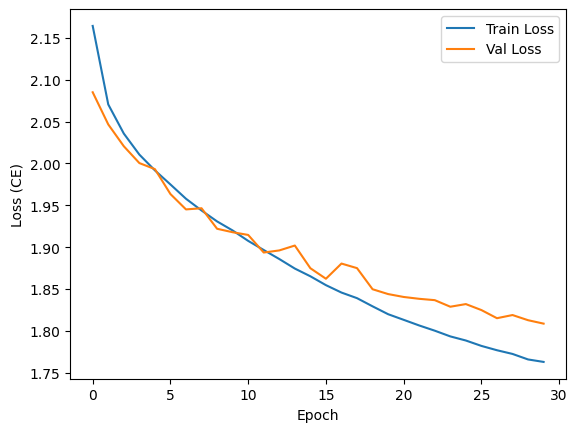

In [16]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses  , label='Val Loss')

plt.ylabel('Loss (CE)')
plt.xlabel('Epoch')

plt.legend()
plt.show()

Epoch: 0, train_loss=1.7551019772338867, val_loss=1.8046995443344116. labelled 6590/10000 correctly (65.9% accuracy)
Epoch: 1, train_loss=1.7506827296447753, val_loss=1.813359407043457. labelled 6488/10000 correctly (64.88000000000001% accuracy)
Epoch: 2, train_loss=1.7459490618896485, val_loss=1.804120902633667. labelled 6571/10000 correctly (65.71000000000001% accuracy)
Epoch: 3, train_loss=1.7397016929626465, val_loss=1.798311710357666. labelled 6623/10000 correctly (66.23% accuracy)
Epoch: 4, train_loss=1.7348812769317628, val_loss=1.800918704032898. labelled 6605/10000 correctly (66.05% accuracy)
Epoch: 5, train_loss=1.7311488029098512, val_loss=1.7932278301239013. labelled 6686/10000 correctly (66.86% accuracy)
Epoch: 6, train_loss=1.7252184735870362, val_loss=1.7956972087860108. labelled 6662/10000 correctly (66.62% accuracy)
Epoch: 7, train_loss=1.7204842153167725, val_loss=1.793220263671875. labelled 6678/10000 correctly (66.78% accuracy)
Epoch: 8, train_loss=1.714989622344970

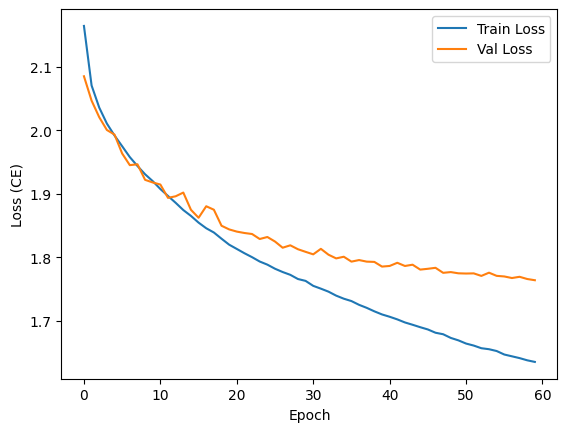

CPU times: user 6min 4s, sys: 1.78 s, total: 6min 6s
Wall time: 6min 10s


In [17]:
%%time
lr = 1e-2 # 1e-2
for epoch_no in range(num_epochs):

  model.train()  # convert to train model. This turns out train-specific layers in the model (if you dont know about them, an example of them is dropout. more on this later)

  epoch_weighted_loss = 0

  for batch_X, batch_y in train_loader:

    batch_X = batch_X.to(device)
    batch_y = batch_y.to(device)

    batch_y_probs = model(batch_X)  # outputs [N, 10] where each [:, 10] is probabilities for class (0-9)

    loss = criterion(batch_y_probs, batch_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_weighted_loss += (len(batch_y)*loss.item())

  epoch_loss = epoch_weighted_loss/len(train_loader.dataset)
  train_losses.append(epoch_loss)


  # validation time

  model.eval()  # take model to evaluation mode. turn off train-only layers
  correctly_labelled = 0

  with torch.no_grad():

    val_epoch_weighted_loss = 0

    for val_batch_X, val_batch_y in val_loader:

      val_batch_X = val_batch_X.to(device)
      val_batch_y = val_batch_y.to(device)

      val_batch_y_probs = model(val_batch_X)

      loss = criterion(val_batch_y_probs, val_batch_y)
      val_epoch_weighted_loss += (len(val_batch_y)*loss.item())

      val_batch_y_pred = val_batch_y_probs.argmax(dim=1)  # convert probailities to labels by picking the label (index) with the highest prob

      correctly_labelled += (val_batch_y_pred == val_batch_y).sum().item()  # item converts tensor to float/int/list

  val_epoch_loss = val_epoch_weighted_loss/len(val_loader.dataset)
  val_losses.append(val_epoch_loss)

  print(f'Epoch: {epoch_no}, train_loss={epoch_loss}, val_loss={val_epoch_loss}. labelled {correctly_labelled}/{len(val_loader.dataset)} correctly ({correctly_labelled/len(val_loader.dataset)*100}% accuracy)')

print(f'Training complete on device {device}.')

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses  , label='Val Loss')

plt.ylabel('Loss (CE)')
plt.xlabel('Epoch')

plt.legend()
plt.show()